# Activity 3: Detect linear regression problems

It is your task to investigate what goes wrong in the Boston House prices dataset.  You should focus on the average number of rooms per dwelling (*RM*) and the percentage of lower status population (*LSTAT*) on median value of houses (*MEDV*).   

NB. Please note that the link below of UCI ML housing dataset is no longer available. Instead, you should consult https://archive.ics.uci.edu/ml/machine-learning-databases/housing/

In [1]:
#Load the boston housing data set
import numpy as np
import pandas as pd
from sklearn import datasets

dataset = datasets.load_boston()

print(dataset["DESCR"])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [2]:
#Separate the variables and the target
X = dataset['data']
y = dataset['target']

#Set as a Pandas data frame
var_names = dataset['feature_names']
data = pd.DataFrame(X)
data.columns = var_names
data['TARGET'] = pd.DataFrame(y)

data.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


The main assumption that you want to test first is whether there is a **linear relationship** between the predictors and the response. There are two ways to do this: before modelling the regression model or afterwards. The best way to spot linear relationships before modelling is by **building scatter plots**. In fact, by building scatterplots, you can also spot whether the data is normally distributed. 

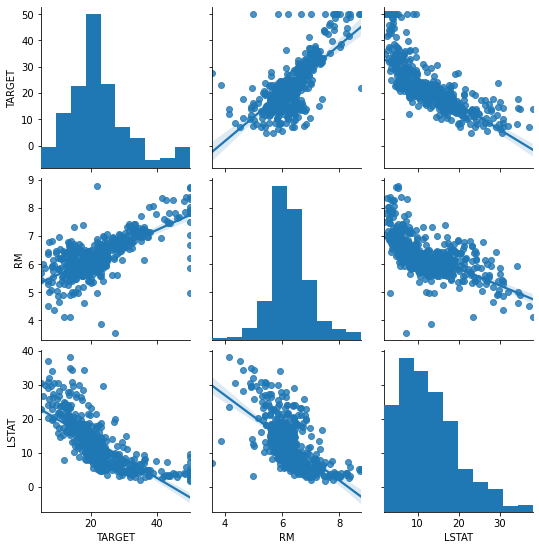

In [3]:
#Limit the colums to TARGET, RM, and LSTAT
data = data[['TARGET', 'RM', 'LSTAT']]

import matplotlib.pyplot as plt
import seaborn as sea

#Make a scatterplot using the seaborn package
#By adding the option 'reg', we can immeadiately add a regression line to the scatter plots.
sea.pairplot(data, kind = "reg")
plt.show()

At first sight, the house prices seem normally distributed - with the exception of some outliers - as well as the average rooms per dwelling. The relationship between the house prices and the average rooms per dwelling also seems to be linear. 

However, the relationship between *LSTAT* and the house prices seems to be non-linear. Also the *LSTAT* variable does not have a normal distribution, but is right skewed. To ascertain whether some of the assumptions are actually violated, let's **build a multiple linear regression model and make a residual plot and a Q-Q plot.** 

In [4]:
#First make a function that create a linear regression model
def make_slr(data):
    
    ### BEGIN SOLUTION
    import statsmodels.api as sm
    data_const = sm.add_constant(data)
    lm = sm.OLS(data_const["TARGET"],data_const[["const","RM", "LSTAT"]]).fit()
    ### END SOLUTION
    
    return lm 

Verify your results:

In [5]:
lm = make_slr(data)
assert np.allclose(lm.params, (-1.35827281,  5.09478798, -0.64235833))

**Residual plot**:

In [6]:
#Using the linear regression model, you can build a residual plot
def make_residual(lm, data, yvar):
    
    ### BEGIN SOLUTION
    plot_resid = sea.residplot(lm.fittedvalues, yvar, data=data,
                          lowess=True, 
                          scatter_kws={'color': 'blue'}, 
                          line_kws={'color': 'red'})
    plot_resid.axes.set_title('Residual Plot Normal Regression')
    plot_resid.axes.set_xlabel('Fitted values')
    plot_resid.axes.set_ylabel('Residuals')
    ### END SOLUTION
    
    return plot_resid

Verify your results: 

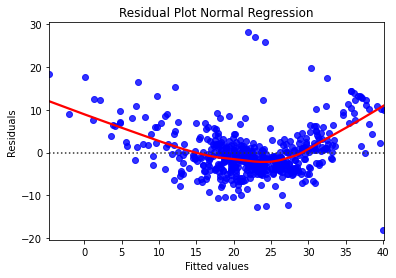

In [10]:
plot_resid = make_residual(lm, data, "TARGET")
plt.show()
assert np.allclose(plot_resid.get_data_ratio(),1.1349048435675755)

**Q-Q plot **:

In [8]:
#This functions makes a q-q plot from the residuals.
def make_qq(lm): 
    
    ### BEGIN SOLUTION
    from scipy import stats
    plot_qq = stats.probplot(lm.resid, plot= plt)
    ### END SOLUTION
    
    return plot_qq

Verify your results: 

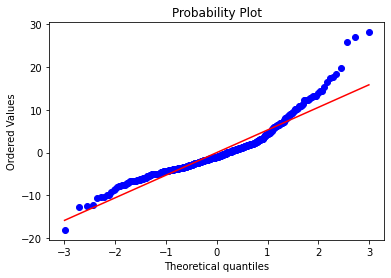

In [9]:
plot_qq = make_qq(lm)
plt.show()

assert np.allclose(plot_qq[1],(5.2874860302319036, 1.5053395508593428e-14, 0.95240142277778117))

From the residual and Q-Q plots, we can make several conclusions. In the residual plot we clearly see a parabolic shape. If there is a parabolic shape in the residual plot, this can serve as an evidence that there is a polynomial relationship between the predictor(s) and response. 

When looking back at the histograms, we know that the relationship between *RM* and house prices is linear, but there is a non-linear relationship between *LSTAT* and house price. A solution might be to add a squared term of *LSTAT* to solve this non-linear relationship - since we notice a parabolic shape, a second degree polynomial is the most fitted. 

In the Q-Q plot, we also notice that the data is non-normal. Since we noticed that there might be a non-linear relationship, it is better to first solve this problem and then check whether the data is still non-normally distributed.